In [1]:
# Setup paths and imports
import os
import sys
from pathlib import Path

ROOT = str(Path().resolve().parents[1])
sys.path.append(ROOT)
os.chdir(ROOT)

# For numerics
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

# For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import from various modules
from thesis_code.phys.constants import me, mm, mt
from thesis_code.lfv_lepton_observables.limits import (radiative_decay_limit,
                                                       radiative_processes,
                                                       trilepton_decay_limit,
                                                       trilepton_processes,
                                                       magnetic_dipole_moment_limit,
                                                       g_2_explanation)
from thesis_code.lepton_nucleus_collisions.experiments import EIC, MuBeD, MuSIC
from thesis_code.lepton_nucleus_collisions.limits import EIC_limit, MuBeD_limit, MuSIC_limit
from thesis_code.lfv_higgs_decays.limits import Cll_limit

# Limits on LFV ALPs and Scalars at Lepton Nucleus Colliders

In [2]:
# Some set-up for plots involving the lepton-nucleus collider experiments
experiments = [EIC, MuBeD, MuSIC]
experiment_colors = [colors[0], colors[3], colors[2]]
color_dict = dict(zip(experiments, experiment_colors))

## LFV ALPs

Here, we plot all of the limits on LFV ALPs from lepton-nucleus colliders presented in the thesis.

In [3]:
# A helper function for computing the limits from lepton decays.

def lepton_decay_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):
    
    limit = {}
    if which == 'radiative':
        for process in radiative_processes:
            limit[process] = radiative_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True, confidence = confidence)
    elif which == 'trilepton':
        for process in trilepton_processes:
            limit[process] = trilepton_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True, confidence = confidence)
    return limit

# A helper function for computing the limits on LFV ALPs from lepton dipole moments.

def lepton_dipole_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):
    
    limit = {}
    for i in range(3):
        limit[i] = factor * magnetic_dipole_moment_limit(ma, i, ij, g = Cll, mode = mode, ALP = True, confidence = confidence)
        
    return limit

# A helper function for plotting the limits on LFV ALPs from lepton decays and dipole moments.

def plot_lepton_observable_limits(ma, ij, ax = None, Cll = np.ones((3,3)), ALP = True,
                                  color = colors[8], plot_lines = False,
                                  include_dipole = False,
                                  radiative_color = colors[3],
                                  trilepton_color = colors[4],
                                  dipole_color = colors[5]):
    if not ax:
        ax = plt.gca()
        
    PC_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'radiative').values())
    PC_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'trilepton').values())
    PC_limits = PC_radiative_limits+PC_trilepton_limits
    if include_dipole:
        PC_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'PC').values())
        PC_limits = PC_limits + PC_dipole_limits
        
    chiral_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'radiative').values())
    chiral_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'trilepton').values())
    chiral_limits = chiral_radiative_limits+chiral_trilepton_limits
    if include_dipole:
        chiral_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'chiral', ALP = ALP).values())
        chiral_limits = chiral_limits + chiral_dipole_limits
    
    absolute_chi_limit = np.nanmin(chiral_limits, axis = 0)
    absolute_PC_limit = np.nanmin(PC_limits, axis = 0)
    absolute_limit = np.nanmin(PC_limits+chiral_limits, axis = 0)
    
    ax.fill_between(ma, absolute_limit, 1e8, color = color, alpha = 0.1)
    ax.plot(ma, absolute_chi_limit, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(ma, absolute_PC_limit,color = 'black', linewidth = 0.5)
    ax.plot(ma, absolute_limit, color = 'black', linewidth = 0.5)
    
    if plot_lines:
        for chi, PC in zip(chiral_radiative_limits, PC_radiative_limits):
            ax.plot(ma, PC, color = radiative_color, linewidth = 0.5)
            ax.plot(ma, chi, color = radiative_color, linestyle = 'dotted', linewidth = 0.5)
        for chi, PC in zip(chiral_trilepton_limits, PC_trilepton_limits):
            ax.plot(ma, PC, color = trilepton_color, linewidth = 0.5)
            ax.plot(ma, chi, color = trilepton_color, linestyle = 'dotted', linewidth = 0.5)
        if include_dipole:
            for chi, PC in zip(chiral_dipole_limits, PC_dipole_limits):
                ax.plot(ma, PC, color = dipole_color, linewidth = 0.5)
                ax.plot(ma, chi, color = dipole_color, linestyle = 'dotted', linewidth = 0.5)
    return ax

# A helper function for plotting the limits on LFV ALPs from Higgs decays at the LHC.

def plot_Higgs_decay_limits(ma, Cah, ax = None, which = 'Cah', ij = (0, 2), Cll = [[1]*3]*3,  CMS_color = colors[0], ATLAS_color = colors[1], lifetime_lines = True):

    if not ax:
        ax = plt.gca()
    
    ############# Constraints ##############

    #######################
    #         CMS         #
    #######################
    
    Cll_limits_CMS = Cll_limit(ma, Cah,
                               which = which,
                               ij = ij,
                               Cll_range = (1e-10, 1e2),
                               npts = 400,
                               detector = 'CMS',
                               Cll = Cll
                               )
    
    #######################
    #        ATLAS        #
    #######################

    Cll_limits_ATLAS = Cll_limit(ma, Cah,
                                 ij = ij,
                                 which = which,
                                 Cll_range = (1e-10, 1e2),
                                 npts = 400,
                                 detector = 'ATLAS',
                                 Cll = Cll
                                 )

    ############# Projections ##############

    Cll_projections = Cll_limit(ma, Cah,
                                which = which,
                                ij = ij,
                                Cll_range = (1e-10, 1e2),
                                npts = 400,
                                detector = ['CMS', 'ATLAS', 'MATHUSLA'],
                                projection = True,
                                Cll = Cll
                              )

    if lifetime_lines:
        #First, plot lifetime contours
        for exp in range(-12, 7, 3):
            ta = 10.0**exp
            Cij_from_ta = ta_to_Cij(ta, ma, Cll = Cll, idx = ij)
            ax.plot(ma, Cij_from_ta, color = 'black', linewidth = 0.25)
            
            plt.text(53.5, 1.35*ta_to_Cij(ta, 62.5, Cll = Cll, idx = ij), f'$c\\tau_a = 10^{{{exp}}}~{{\\rm m}}$', fontsize = 10)

    #Projections
    for limit in Cll_projections:
        ax.plot(*limit, color = 'black', dashes = (8, 8), linewidth = 0.5)
        ax.fill(*limit, color = 'grey' , alpha = 0.075)

    #CMS
    for limit in Cll_limits_CMS:
        ax.fill(*limit, color = CMS_color, edgecolor = 'black', alpha = 0.6)

    #ATLAS
    for limit in Cll_limits_ATLAS:
        ax.fill(*limit, color = ATLAS_color, edgecolor = 'black', alpha = 0.6)

    # Format tick parameters
    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)

    # x-axis
    ax.set_xlim(1.77, 62.5)
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 14)
    
    #y-axis
    ax.set_ylim(1e-9, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel('$C_{\\tau \\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
    
    return ax
    
def plot_ALP_limits(ma, ij, Cah,
                    ax = None,
                    which = 'Cahp',
                    Cll = [[1]*3]*3,
                    include_dipole = False,
                    EIC_params = None,
                    MuBeD_params = None,
                    MuSIC_params = None
                   ):

    if not ax:
        ax = plt.gca()
    
    #LFV lepton decay limits (color yellow)
    plot_lepton_observable_limits(ma, ij, ax = ax, Cll = Cll, include_dipole = include_dipole)
    
    #Higgs decay limits (color gray)
    plot_Higgs_decay_limits(ma, Cah, ij = ij, ax = None, which = which, Cll = Cll, CMS_color = 'gray', ATLAS_color = 'gray', lifetime_lines = False)

    # Lepton-nucleus collider limits
    param_list = [EIC_params, MuBeD_params, MuSIC_params]
    limit_functions = [EIC_limit, MuBeD_limit, MuSIC_limit]
    for idx, (experiment, limit_func, experiment_params) in enumerate(zip(experiments, limit_functions, param_list)):
        if experiment_params:
            if type(experiment_params) != list:
                experiment_params = [experiment_params]

            t_cut_off = 1.0 if experiment == MuBeD else 0.01 # Avoid nuclear break-up at EIC and MuSIC

            styles = ['solid', 'dashed', 'dotted', 'dashdot']
            for i, params in enumerate(experiment_params):

                limit = limit_func(ma, g = Cll, idx = ij, **params)
                
                # Plot the limit
                plt.plot(ma, limit, color = color_dict[experiment], linewidth = 1, linestyle = styles[i%4])

    return ax

### EIC

#### $C_{\tau e}$ only non-zero coupling

Here, we consider the scenario where $C_{\tau e}$ is non-zero but the rest of the couplings are zero. This scenario can be probed at the EIC and provide an explanation to the electron $g-2$ anomalies.

First, we plot constraints on $C_{\tau e}$ from the EIC assuming $\tau$ efficiencies $\epsilon_\tau = 1\%$ and $\epsilon_\tau = 10\%$.

Text(0, 0.5, '$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$')

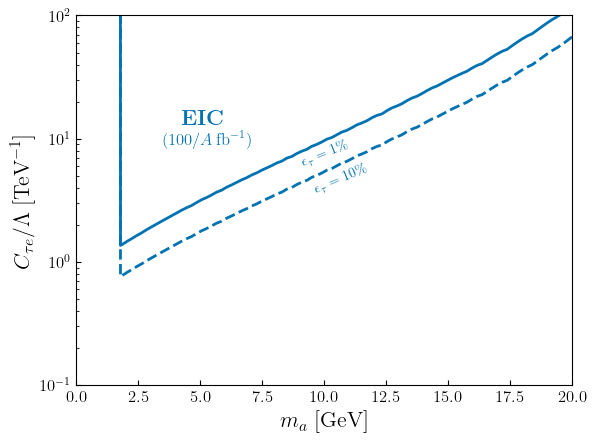

In [4]:
Cll = [[0, 0, 1], # Coupling hierarchy matrix 
       [0, 0, 0], # (only C_{\tau e} non-zero)
       [1, 0, 0]]
ij = (0, 2) # Plotting constraints on C_{\tau e}

# Conservative and optimistic EIC scenarios
EIC_conservative = {'tau_efficiency': 0.01}
EIC_optimistic = {'tau_efficiency': 0.1}

ma = np.linspace(0, 20, 100)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))

styles = ['solid', 'dashed']
for i, params in enumerate([EIC_conservative, EIC_optimistic]):
    limit = EIC_limit(ma, g= Cll, idx = ij, **params)
    plt.plot(ma, limit, color = color_dict[EIC], linestyle = styles[i], linewidth = 2)

# Text for EIC
plt.text(4.2, 13, '${\\bf EIC}$', color = color_dict[EIC], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[EIC], fontsize = 12)

# Text specifying tau efficiency
plt.text(9.5, 3.6, '$\\epsilon_\\tau = 10\\%$', rotation = 23, color = color_dict[EIC])
plt.text(9, 6, '$\\epsilon_\\tau = 1\\%$', rotation = 22, color = color_dict[EIC])

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# x-axis
plt.xlim(0, 20)
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(1e-1, 1e2)
plt.yscale('log')
plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

We can compare these to the constraints from the LHC on LFV ALPs, modifying them so that they apply for $C_{\tau e} \neq 0$ only:

Text(0.5, 1.0, '$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

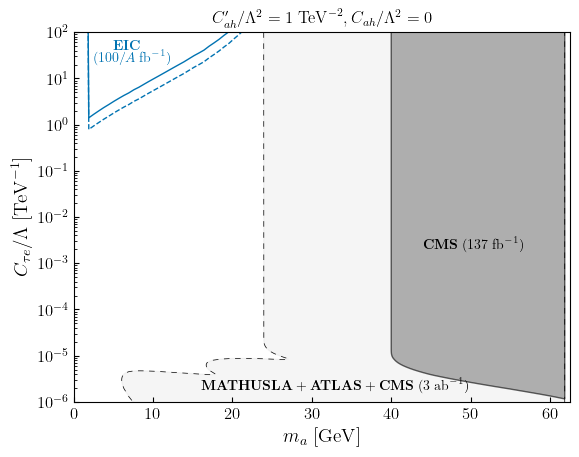

In [5]:
Cll = [[0, 0, 1], # Coupling hierarchy matrix
       [0, 0, 0], # (only C_{\tau e} non-zero)
       [1, 0, 0]]
ij = (0, 2) # Plotting constraints on C_{\tau e}

Cah = 1e0
which = 'Cahp' #plotting limits with Cah' = 1.0/TeV^2

ma = np.linspace(0, 62.5, 100)

# Conservative and optimistic EIC scenarios
EIC_conservative = {'tau_efficiency': 0.01}
EIC_optimistic = {'tau_efficiency': 0.1}

# Compute and plot the limits
ax = plot_ALP_limits(ma, ij, Cah, which = which, Cll = Cll, EIC_params = [EIC_conservative, EIC_optimistic])

# Text for experiments
ax.text(5, 42, '${\\bf EIC}$', color = color_dict[EIC], fontsize = 10)
ax.text(2.5, 22, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[EIC], fontsize = 10)
ax.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
ax.text(16, 1.8e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

# x-axis
ax.set_xlim(0, 62.5)

# y-axis
ax.set_ylim(1e-6, 1e2)
ax.set_yscale('log')
ax.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

# Title
ax.set_title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

For the thesis, we plot these side by side in a single figure:

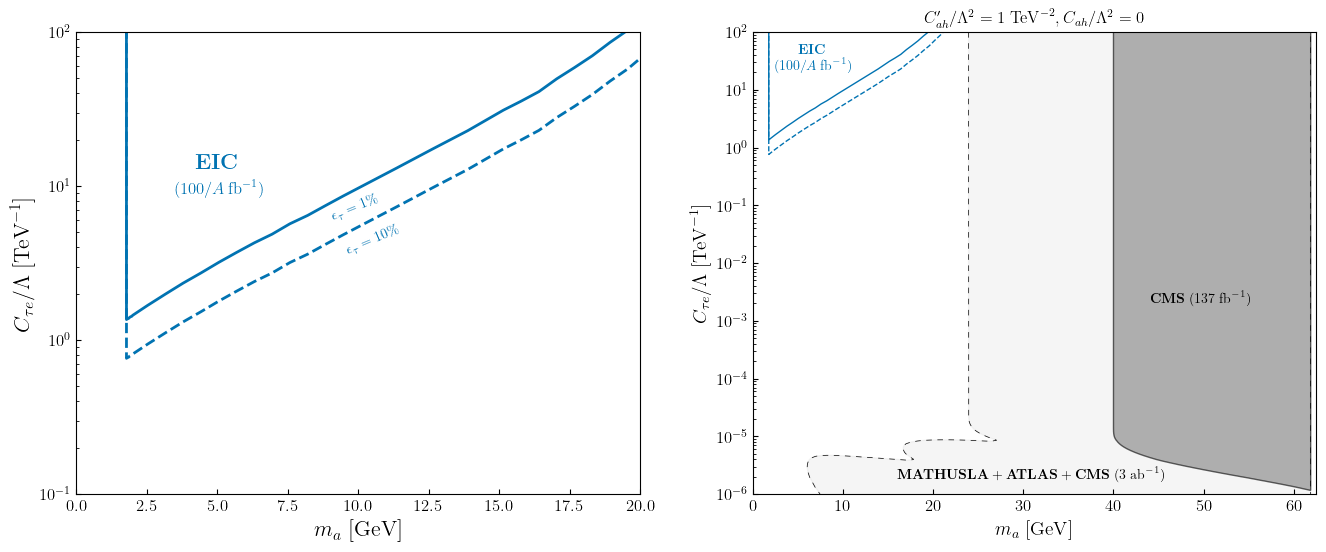

In [6]:
Cll = [[0, 0, 1], # Coupling hierarchy matrix 
       [0, 0, 0], # (only C_{\tau e} non-zero)
       [1, 0, 0]]
ij = (0, 2) # Plotting constraints on C_{\tau e}

ma = np.linspace(0, 62.5, 100)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100))) # Finer precision near tau mass threshold

fig = plt.figure(figsize = (16, 6))
gs = GridSpec(1, 2, wspace = 0.2)

# LEFT PLOT
ax1 = fig.add_subplot(gs[0])

# Conservative and optimistic EIC scenarios
EIC_conservative = {'tau_efficiency': 0.01}
EIC_optimistic = {'tau_efficiency': 0.1}

# Compute and plot the limits
styles = ['solid', 'dashed']
for i, params in enumerate([EIC_conservative, EIC_optimistic]):
    limit = EIC_limit(ma, g= Cll, **params)
    ax1.plot(ma, limit, color = color_dict[EIC], linestyle = styles[i], linewidth = 2)
    
# Text for EIC
ax1.text(4.2, 13, '${\\bf EIC}$', color = color_dict[EIC], fontsize = 16)
ax1.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[EIC], fontsize = 12)

# Text specifying tau efficiency
ax1.text(9.5, 3.6, '$\\epsilon_\\tau = 10\\%$', rotation = 23, color = color_dict[EIC])
ax1.text(9, 6, '$\\epsilon_\\tau = 1\\%$', rotation = 22, color = color_dict[EIC])

# format tick parameters
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# x-axis
ax1.set_xlim(0, 20)
ax1.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax1.set_ylim(1e-1, 1e2)
ax1.set_yscale('log')
ax1.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

# RIGHT PLOT
ax2 = fig.add_subplot(gs[1])

Cah = 1e0
which = 'Cahp' #plotting limits with Cah' = 1.0/TeV^2

# Compute and plot limits
plot_ALP_limits(ma, ij, Cah, ax = ax2, which = which, Cll = Cll, EIC_params = [EIC_conservative, EIC_optimistic])

# Text for experiments
ax2.text(5, 42, '${\\bf EIC}$', color = color_dict[EIC], fontsize = 10)
ax2.text(2.5, 22, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[EIC], fontsize = 10)
ax2.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
ax2.text(16, 1.8e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

# x-axis
ax2.set_xlim(0, 62.5)

# y-axis
ax2.set_ylim(1e-6, 1e2)
ax2.set_yscale('log')
ax2.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

# Title
ax2.set_title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

# Save figure
plt.savefig('figures/chapter5/EIC_ALP_limits.pdf', format = 'pdf',bbox_inches='tight')

We can also plot the PV LFV ALP explanations to the electron $g-2$ anomalies that the EIC is sensitive to:

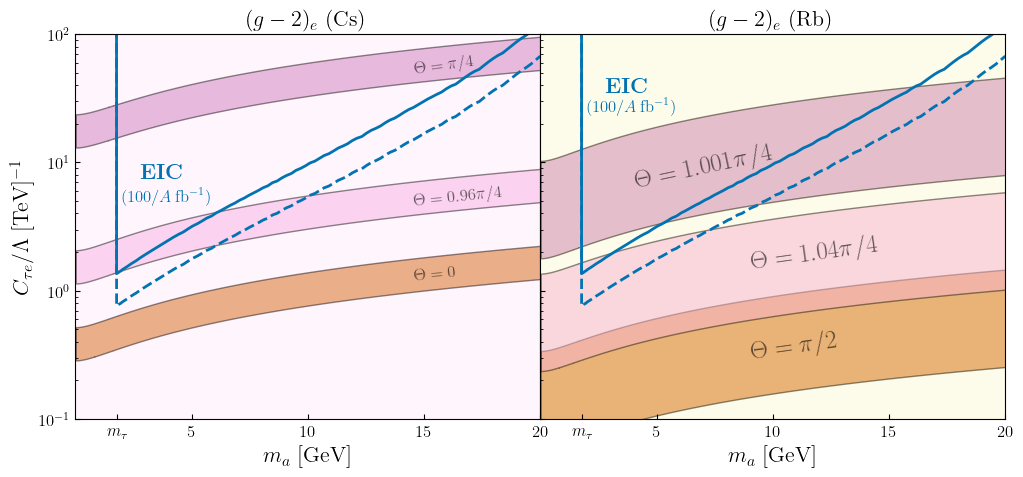

In [7]:
Cll = [[0, 0, 1], # Coupling hierarchy matrix 
       [0, 0, 0], # (only C_{\tau e} non-zero)
       [1, 0, 0]]
ij = (0, 2) # Plotting constraints on C_{\tau e}

fig = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 2, wspace = 0)

# Conservative and optimistic EIC scenarios
EIC_conservative = {'tau_efficiency': 0.01}
EIC_optimistic = {'tau_efficiency': 0.1}

ma = np.linspace(0, 20, 100)
ma = np.sort(np.append(ma, np.linspace(0.0, 2.0, 100)))

# Compute EIC limits
EIC_limits = [EIC_limit(ma, g = Cll, idx = ij, **params) for params in [EIC_conservative, EIC_optimistic]]
styles = ['solid', 'dashed']

# LEFT PLOT (Cesium anomaly)
ax1 = fig.add_subplot(gs[0]) 

# Plot EIC limits
for limit, style in zip(EIC_limits, styles):
    ax1.plot(ma, limit, color = color_dict[EIC], linewidth = 2, linestyle = style)

# Text for EIC
ax1.text(2.8, 7.6, '${\\bf EIC}$', fontsize = 16, color = color_dict[EIC])
ax1.text(2., 5, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = color_dict[EIC])

# Plot explanations to Cesium anomaly for different angles
angles = np.array([0, 0.96, 1])*np.pi/4
angle_colors = [colors[3], colors[6], colors[4]]
for angle, color in zip(angles, angle_colors):
    ax1.fill_between(ma, *g_2_explanation(ma, 'e Cs', ij, th = angle*np.ones((3, 3)), ALP = True),
                     alpha = 0.5, color = color, edgecolor = 'black')

# Text specifying each angle
ax1.text(14.5, 50, '$\\Theta = \\pi/4$', rotation = 8, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 4.7, '$\\Theta = 0.96\\pi/4$', rotation = 6, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 1.2, '$\\Theta = 0$', rotation = 6, fontsize = 12, alpha = 0.6)

# Color the plot background
ax1.fill_between(ma, 1e-1, 1e2, color = colors[6], alpha = 0.1)

# Axis parameters

# x-axis
ax1.set_xlim(0, 20)
ax1.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12)
ax1.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax1.set_ylim(1e-1, 1e2)
ax1.set_yscale('log')
ax1.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}]^{-1}$', fontsize = 16)

# Title
ax1.set_title('$(g-2)_e~({\\rm Cs})$', fontsize = 16)

# RIGHT PLOT (Rubidium anomaly)
ax2 = fig.add_subplot(gs[1]) 

# Plot EIC limits
for limit, style in zip(EIC_limits, styles):
    ax2.plot(ma, limit, color = color_dict[EIC], linewidth = 2, linestyle = style)

# Text for EIC
ax2.text(2.8, 35.3, '${\\bf EIC}$', fontsize = 16, color = color_dict[EIC])
ax2.text(2., 25, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = color_dict[EIC])

# Plot explanations to Rubidium anomaly for different angles
angles = np.array([2.0, 1.04, 1.001]) * np.pi/4
angle_colors = [colors[3], colors[6], colors[4]]
for angle, color in zip(angles, angle_colors):
    ax2.fill_between(ma, *g_2_explanation(ma, 'e Rb', ij, th = angle*np.ones((3, 3)), ALP = True),
                     alpha = 0.5, color = color, edgecolor = 'black')

# Text specifying PV angle
ax2.text(4, 6.5, '$\\Theta = 1.001\\pi/4$', rotation = 12, fontsize = 18, alpha = 0.6)
ax2.text(9, 1.5, '$\\Theta = 1.04\\pi/4$', rotation = 8, fontsize = 18, alpha = 0.6)
ax2.text(9, 0.3, '$\\Theta = \\pi/2$', rotation = 8, fontsize = 18, alpha = 0.6)

# Color the plot background
ax2.fill_between(ma, 1e-1, 1e2, color = colors[8], alpha = 0.1)

# Axis specifications

# x-axis
ax2.set_xlim(0, 20)
ax2.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax2.tick_params(which = 'both', direction = 'in', labelleft = False, labelsize = 12)
ax2.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e2)

# Title
ax2.set_title('$(g-2)_e~({\\rm Rb})$', fontsize = 16)

# Save figure
plt.savefig('figures/chapter5/EIC_ALP_electron_g_2.pdf', format = 'pdf',bbox_inches='tight')

Finally, we can plot the region in $m_a$-$\Theta$ space for which the EIC probes an explanation to one of the electron $g-2$ anomalies.

In [8]:
from phys.utils import find_contours

Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

masses = np.linspace(0, 25, 100)
masses = np.sort(np.append(masses, np.linspace(1, 2, 100)))

# List of angles to scan over
theta = np.linspace(0.5, 1.2, 10000) * np.pi/4 

# Convert couplings and angles to a matrix that
# can be passed through the g_2_explanation function
Cll_mat = np.array(Cll).reshape(3, 3, 1, 1).repeat(10000, axis = 3)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

Cs_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Cs', (2, 0), g = Cll_mat, th = theta_mat, ALP = True)
Cs_max = np.max(Cs_explanation, axis = 0)

Rb_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Rb', (2, 0), g = Cll_mat, th = theta_mat, ALP = True)
Rb_max = np.max(Rb_explanation, axis = 0)

# Conservative and optimistic limits on Cet from the EIC
Cet_EIC_cons = EIC_limit(masses, g = Cll, tau_efficiency = 0.01, ALP = True).reshape(-1, 1)
Cet_EIC_opt = EIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True).reshape(-1, 1)

#We want those values of m and theta for which C_explanation > C_EIC_lim
Cs_line = find_contours(masses, theta, (Cs_max - Cet_EIC_cons), 0)[0]
Rb_line = find_contours(masses, theta, (Rb_max - Cet_EIC_cons), 0)[0]

Cs_line_opt = find_contours(masses, theta, (Cs_max - Cet_EIC_opt), 0)[0]
Rb_line_opt = find_contours(masses, theta, (Rb_max - Cet_EIC_opt), 0)[0]

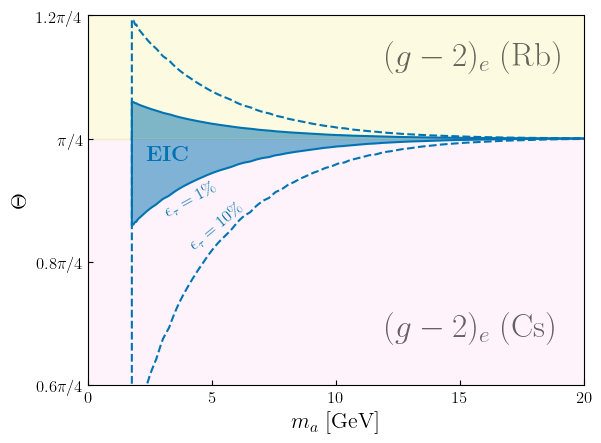

In [9]:
# Color plot
plt.fill_between(masses, 0.1*np.pi, np.pi/4-me/mt, color = colors[6], alpha = 0.15)
plt.fill_between(masses, np.pi/4-me/mt, 1.3*np.pi, color = colors[8], alpha = 0.15)

# Fill between conservative region
plt.fill_between(*Cs_line, np.pi/4, color = color_dict[EIC], alpha = 0.5, edgecolor = None)
plt.fill_between(*Rb_line, np.pi/4, color = color_dict[EIC], alpha = 0.5, edgecolor = None)

# Plot the outline of the conservative region
plt.plot(*Cs_line, color = color_dict[EIC])
plt.plot(*Rb_line, color = color_dict[EIC])

# Close the region at m_a = m_\tau
#plt.plot([1.77, 1.77], [Cs_line[1][Cs_line[0].argmin()], Rb_line[1][Rb_line[0].argmin()]], color = colors[0])

# Plot the outline of the optimistic region
plt.plot(*Cs_line_opt, color = color_dict[EIC], linestyle = 'dashed')
plt.plot(*Rb_line_opt, color = color_dict[EIC], linestyle = 'dashed')

# Close the region at m_a = m_\tau
#plt.plot([1.77, 1.77], [Cs_line_opt[1][Cs_line_opt[0].argmin()], Rb_line_opt[1][Rb_line_opt[0].argmin()]], color = colors[0], linestyle = 'dashed')

# Text for EIC
plt.text(2.35, 0.965*np.pi/4, '${\\bf EIC}$', fontsize = 16, color = colors[0])
plt.text(3, 0.873*np.pi/4, '$\\epsilon_\\tau = 1\%$', rotation = 29, fontsize = 12, color = colors[0])
plt.text(4., 0.82*np.pi/4, '$\\epsilon_\\tau = 10\%$', rotation = 40, fontsize = 12, color = colors[0])

# Text identifying which anomaly is being probed
plt.text(12, 0.28*np.pi, '$(g-2)_{e}~({\\rm Rb})$', fontsize = 24, alpha = 0.6)
plt.text(12, 0.17*np.pi, '$(g-2)_{e}~({\\rm Cs})$', fontsize = 24, alpha = 0.6)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# x-axis
plt.xlim(0, 20)
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)


# y-axis
plt.ylim(0.6*np.pi/4, 1.2*np.pi/4)
yticks = np.round(np.array([0.4 + 0.2*i for i in range(1, 5)]), 2)

plt.yticks(yticks*np.pi/4, [f'$\\pi/4$' if tick == 1 else f'${tick}\\pi/4$' for tick in yticks])
plt.ylabel('$\\Theta$', fontsize = 16)

# Save figure
plt.savefig('figures/chapter5/EIC_g_2_probe.pdf', format = 'pdf',bbox_inches='tight')

### MuBeD and MuSIC

#### $C_{\tau\mu}$ only non-zero coupling

Here, we consider the scenario where $C_{\tau \mu}$ is non-zero but the rest of the couplings are zero. This scenario can be probed at MuBeD and MuSIC and provide an explanation to the muon $g-2$ anomaly  (although as of writing this, the anomaly appears to be officially resolved).

First, we plot constraints on $C_{\tau \mu}$ from the MuSIC assuming $\tau$ efficiencies $\epsilon_\tau = 1\%$ and $\epsilon_\tau = 10\%$, and MuBeD assuming $10^{15}$ and $10^{20}$ muons on target.

Text(0, 0.5, '$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$')

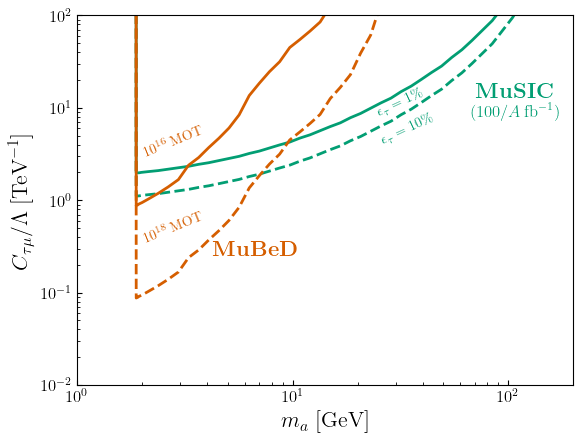

In [10]:
Cll = [[0, 0, 0], # Coupling hierarchy matrix 
       [0, 0, 1], # (only C_{\tau \mu} non-zero)
       [0, 1, 0]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

ma = np.geomspace(1.00, 200, 50)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))

#### MuSIC Limits ####

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}
MuSIC_optimistic = {'tau_efficiency': 0.1}
MuSIC_params = [MuSIC_conservative, MuSIC_optimistic]

# Compute and plot MuSIC limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuSIC_params):
    limit = MuSIC_limit(ma, g= Cll, idx = ij, **params)
    plt.plot(ma, limit, color = color_dict[MuSIC], linestyle = styles[i], linewidth = 2)

# Text for MuSIC
plt.text(70, 13, '${\\bf MuSIC}$', color = color_dict[MuSIC], fontsize = 16)
plt.text(67, 8, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[MuSIC], fontsize = 12)

# Text specifying tau efficiency
plt.text(25, 4, '$\\epsilon_\\tau = 10\\%$', rotation = 25, color = color_dict[MuSIC])
plt.text(24, 8, '$\\epsilon_\\tau = 1\\%$', rotation = 25, color = color_dict[MuSIC])


### MuBeD Limits ####

# Different MuBeD scenarios
MuBeD_1e16 = {'N_MOT': 1e16}
MuBeD_1e18 = {'N_MOT': 1e18}
MuBeD_params = [MuBeD_1e16, MuBeD_1e18] 

# Compute and plot MuBeD limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuBeD_params):
    limit = MuBeD_limit(ma, g= Cll, idx = ij, **params)
    plt.plot(ma, limit, color = color_dict[MuBeD], linestyle = styles[i], linewidth = 2)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# Text for MuBeD
plt.text(4.2, 0.25, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 16)

# Text specifying number of muons on target
plt.text(2, 3e0, '$10^{16}~{\\rm MOT}$', rotation = 22, color = color_dict[MuBeD])
plt.text(2, 3.5e-1, '$10^{18}~{\\rm MOT}$', rotation = 22, color = color_dict[MuBeD])

# x-axis
plt.xlim(1.0, 200)
plt.xscale('log')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

We can compare these to the constraints from the LHC on LFV ALPs, modifying them so that they apply for $C_{\tau \mu} \neq 0$ only:

Text(0.5, 1.0, '$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

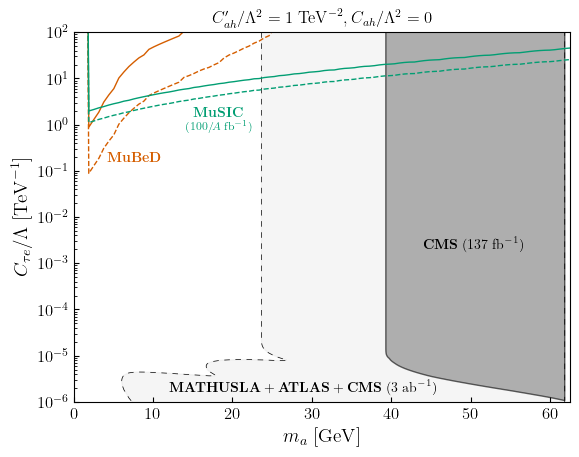

In [11]:
Cll = [[0, 0, 0], # Coupling hierarchy matrix
       [0, 0, 1], # (only C_{\tau \mu} non-zero)
       [0, 1, 0]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

Cah = 1e0
which = 'Cahp' #plotting limits with Cah' = 1.0/TeV^2

ma = np.linspace(0, 62.5, 100)

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}
MuSIC_optimistic = {'tau_efficiency': 0.1}
MuSIC_params = [MuSIC_conservative, MuSIC_optimistic]

# Different MuBeD scenarios
MuBeD_1e16 = {'N_MOT': 1e16}
MuBeD_1e18 = {'N_MOT': 1e18}
MuBeD_params = [MuBeD_1e16, MuBeD_1e18] 

# Compute and plot the limits
ax = plot_ALP_limits(ma, ij, Cah, which = which, Cll = Cll, MuSIC_params = MuSIC_params, MuBeD_params = MuBeD_params)

# Text for experiments
ax.text(15, 1.5, '${\\bf MuSIC}$', color = color_dict[MuSIC], fontsize = 10)
ax.text(14.1, 0.75, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[MuSIC], fontsize = 8)
ax.text(4.2, 1.6e-1, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 10)
ax.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
ax.text(12, 1.6e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

# x-axis
ax.set_xlim(0, 62.5)

# y-axis
ax.set_ylim(1e-6, 1e2)
ax.set_yscale('log')
ax.set_ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

# Title
ax.set_title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

Once again, we combine them into a single figure for the thesis:

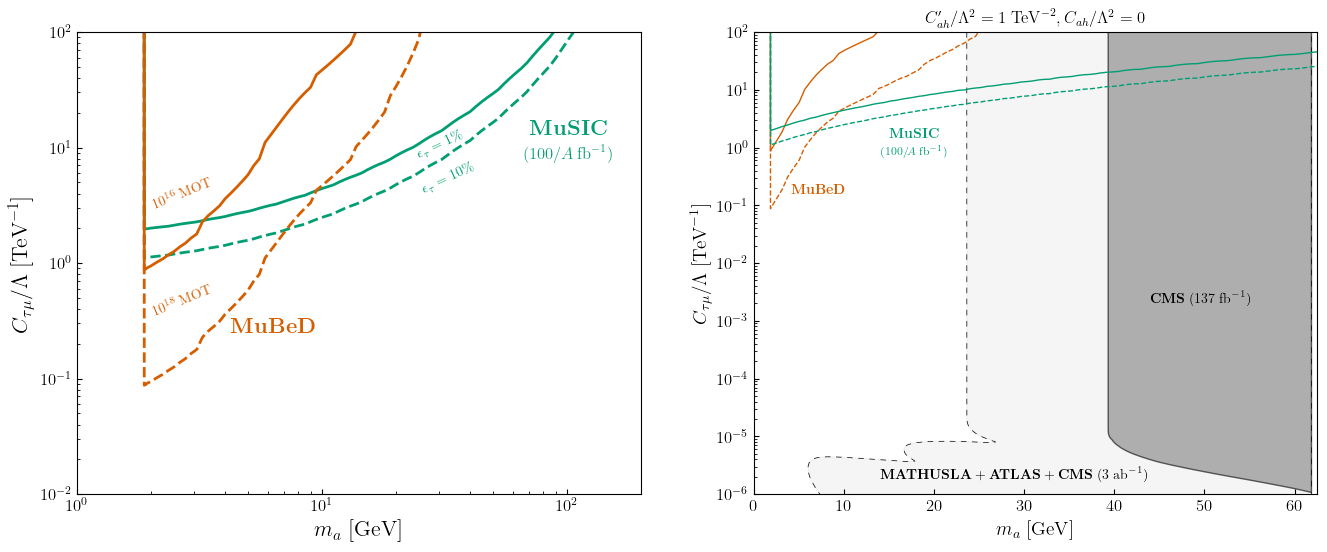

In [12]:
Cll = [[0, 0, 0], # Coupling hierarchy matrix 
       [0, 0, 1], # (only C_{\tau \mu} non-zero)
       [0, 1, 0]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}
MuSIC_optimistic = {'tau_efficiency': 0.1}
MuSIC_params = [MuSIC_conservative, MuSIC_optimistic]

# Different MuBeD scenarios
MuBeD_1e16 = {'N_MOT': 1e16}
MuBeD_1e18 = {'N_MOT': 1e18}
MuBeD_params = [MuBeD_1e16, MuBeD_1e18] 

fig = plt.figure(figsize = (16, 6))
gs = GridSpec(1, 2, wspace = 0.2)

# LEFT PLOT
ax1 = fig.add_subplot(gs[0])

ma = np.geomspace(1.0, 200, 100)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100))) # Finer precision near tau mass threshold

#### MuSIC Limits ####

# Compute and plot MuSIC limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuSIC_params):
    limit = MuSIC_limit(ma, g= Cll, idx = ij, **params)
    ax1.plot(ma, limit, color = color_dict[MuSIC], linestyle = styles[i], linewidth = 2)

# Text for MuSIC
ax1.text(70, 13, '${\\bf MuSIC}$', color = color_dict[MuSIC], fontsize = 16)
ax1.text(67, 8, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[MuSIC], fontsize = 12)

# Text specifying tau efficiency
ax1.text(25, 4, '$\\epsilon_\\tau = 10\\%$', rotation = 25, color = color_dict[MuSIC])
ax1.text(24, 8, '$\\epsilon_\\tau = 1\\%$', rotation = 25, color = color_dict[MuSIC])


### MuBeD Limits ####

# Compute and plot MuBeD limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuBeD_params):
    limit = MuBeD_limit(ma, g= Cll, idx = ij, **params)
    ax1.plot(ma, limit, color = color_dict[MuBeD], linestyle = styles[i], linewidth = 2)

# Format tick parameters
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# Text for MuBeD
ax1.text(4.2, 0.25, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 16)

# Text specifying number of muons on target
ax1.text(2, 3e0, '$10^{16}~{\\rm MOT}$', rotation = 22, color = color_dict[MuBeD])
ax1.text(2, 3.5e-1, '$10^{18}~{\\rm MOT}$', rotation = 22, color = color_dict[MuBeD])

# x-axis
ax1.set_xlim(1.0, 200)
ax1.set_xscale('log')
ax1.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax1.set_ylim(1e-2, 1e2)
ax1.set_yscale('log')
ax1.set_ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

# RIGHT PLOT
ax2 = fig.add_subplot(gs[1])

ma = np.linspace(0, 62.5, 100)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100))) # Finer precision near tau mass threshold

ij = (1, 2) # Plotting constraints on C_{\tau \mu}

Cah = 1e0
which = 'Cahp' #plotting limits with Cah' = 1.0/TeV^2

# Compute and plot the limits
plot_ALP_limits(ma, ij, Cah, ax = ax2, which = which, Cll = Cll, MuSIC_params = MuSIC_params, MuBeD_params = MuBeD_params)

# Text for experiments
ax2.text(15, 1.5, '${\\bf MuSIC}$', color = color_dict[MuSIC], fontsize = 10)
ax2.text(14.1, 0.75, '$(100/A~{\\rm fb}^{-1})$', color = color_dict[MuSIC], fontsize = 8)
ax2.text(4.2, 1.6e-1, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 10)
ax2.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
ax2.text(14, 1.8e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

# x-axis
ax2.set_xlim(0, 62.5)

# y-axis
ax2.set_ylim(1e-6, 1e2)
ax2.set_yscale('log')
ax2.set_ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

# Title
ax2.set_title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

plt.savefig('figures/chapter5/MuSIC_MuBeD_ALP_limits.pdf', format = 'pdf',bbox_inches='tight')

Next, we can plot the PV LFV ALP explanations to the muon $g-2$ anomaly that MuBeD and MuSIC are sensitive to:

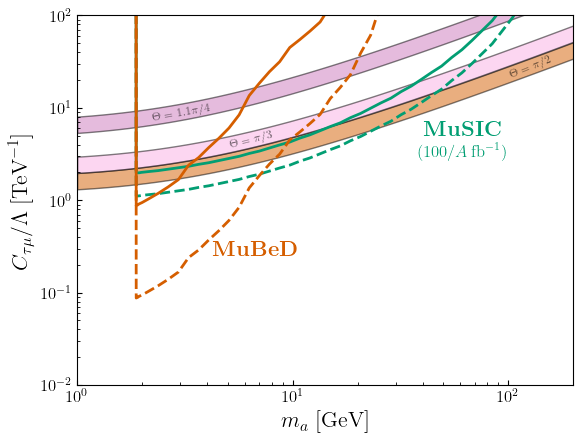

In [13]:
Cll = [[0, 0, 0], # Coupling hierarchy matrix 
       [0, 0, 1], # (only C_{\tau \mu} non-zero)
       [0, 1, 0]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

ma = np.geomspace(1.00, 200, 50)
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100)))

#### MuSIC Limits ####

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}
MuSIC_optimistic = {'tau_efficiency': 0.1}
MuSIC_params = [MuSIC_conservative, MuSIC_optimistic]

# Compute and plot MuSIC limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuSIC_params):
    limit = MuSIC_limit(ma, g= Cll, idx = ij, **params)
    plt.plot(ma, limit, color = color_dict[MuSIC], linestyle = styles[i], linewidth = 2)

# Text for MuSIC
plt.text(40, 5, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)
plt.text(38, 3, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

### MuBeD Limits ####

# Different MuBeD scenarios
MuBeD_1e16 = {'N_MOT': 1e16}
MuBeD_1e18 = {'N_MOT': 1e18}
MuBeD_params = [MuBeD_1e16, MuBeD_1e18] 

# Compute and plot MuBeD limits
styles = ['solid', 'dashed']
for i, params in enumerate(MuBeD_params):
    limit = MuBeD_limit(ma, g= Cll, idx = ij, **params)
    plt.plot(ma, limit, color = color_dict[MuBeD], linestyle = styles[i], linewidth = 2)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# Text for MuBeD
plt.text(4.2, 0.25, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 16)

# x-axis
plt.xlim(1.0, 200)
plt.xscale('log')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

# Plot explanations to muon g-2 anomaly for different angles
angles = np.array([1/2, 1/3, 1.1/4]) * np.pi
angle_colors = [colors[3], colors[6], colors[4]]
for angle, color in zip(angles, angle_colors):
    plt.fill_between(ma, *g_2_explanation(ma, 'mu', ij, th = angle*np.ones((3, 3)), ALP = True),
                     alpha = 0.5, color = color, edgecolor = 'black')

# Text specifying PV angle
plt.text(2.2, 7.3, '$\\Theta = 1.1\\pi/4$', rotation = 10, fontsize = 8, alpha = 0.6)
plt.text(5, 3.7, '$\\Theta = \\pi/3$', rotation = 14, fontsize = 8, alpha = 0.6)
plt.text(100, 21, '$\\Theta = \\pi/2$', rotation = 22, fontsize = 8, alpha = 0.6)

plt.savefig('figures/chapter5/MuSIC_MuBeD_ALP_muon_g_2.pdf', format = 'pdf', bbox_inches='tight')

In [14]:
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]

# List of angles to scan over
theta = np.linspace(np.pi/4, np.pi/2, 10000)


# Convert couplings and angles to a matrix that
# can be passed through the g_2_explanation function
Cll_mat = np.array(Cll).reshape(3, 3, 1, 1).repeat(10000, axis = 3)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

masses = np.geomspace(1, 200, 100)
masses = np.append(masses, np.linspace(1, 2, 100))

g_mu_explanation = g_2_explanation(masses.reshape(-1, 1), 'mu', (2, 1), g = Cll_mat, th = theta_mat, ALP = True)
g_mu_max = np.max(g_mu_explanation, axis = 0)

# Conservative and optimistic limits on Cmt from MuSIC
Cmt_MuSIC_cons = MuSIC_limit(masses, g = Cll, tau_efficiency = 0.01, ALP = True).reshape(-1, 1)
Cmt_MuSIC_opt = MuSIC_limit(masses, g = Cll, tau_efficiency = 0.1, ALP = True).reshape(-1, 1)

# 1e16 and 1e18 muons on target for MuBeD
Cmt_MuBeD_1e16 = MuBeD_limit(masses, g = Cll, N_MOT = 1e16, ALP = True).reshape(-1, 1)
Cmt_MuBeD_1e18 = MuBeD_limit(masses, g = Cll, N_MOT = 1e18, ALP = True).reshape(-1, 1)

#We want those values of m and theta for which C_explanation > C_MuSIC_lim, C_MuBeD_lim

MuSIC_line_cons = find_contours(masses, theta, (g_mu_max - Cmt_MuSIC_cons), 0)[1]
MuBeD_line_1e16 = find_contours(masses, theta, (g_mu_max - Cmt_MuBeD_1e16), 0)[1]

MuSIC_line_opt = find_contours(masses, theta, (g_mu_max - Cmt_MuSIC_opt), 0)[1]
MuBeD_line_1e18 = find_contours(masses, theta, (g_mu_max - Cmt_MuBeD_1e18), 0)[1]

In [15]:
# define a smoothing function to fix jagged edges
def smooth(y, window = 10):
    y_new = np.ones(len(y) + window)
    y_new[window//2:-window//2] = y
    y_new[:window//2] = y[0]
    y_new[-window//2:] = y[-1]
    return np.convolve(y_new, np.ones(window)/window, mode = 'same')[window//2:-window//2]

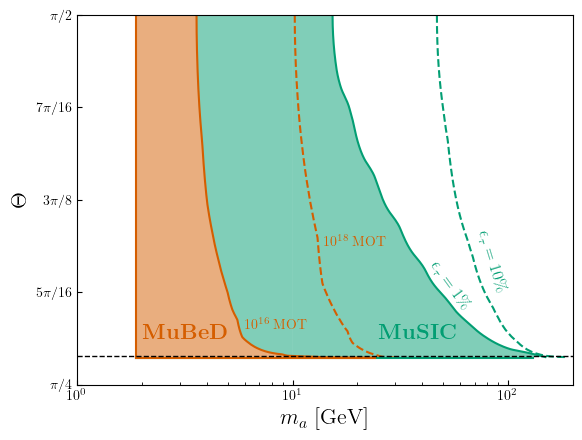

In [16]:
# Fill between conservative MuSIC region
y, x = MuSIC_line_cons[::-1]
x = smooth(x, window = 400)
plt.fill_betweenx(y, x, 10, color = color_dict[MuSIC], alpha = 0.5, edgecolor = None)

# Plot conservative MuSIC region
plt.plot(x, y, color = colors[2])

# Plot optimistic MuSIC region
y, x = MuSIC_line_opt[::-1]
plt.plot(x, y, color = colors[2], linestyle = 'dashed')

# Fill between MuBeD 1e16 region
y, x = MuBeD_line_1e16[::-1]
plt.fill_betweenx(y, x, mt+mm, color = color_dict[MuBeD], alpha = 0.5, edgecolor = None)

# Plot MuBeD 1e16 region
plt.plot(x, y, color = color_dict[MuBeD])

# Fill between MuBeD 1e16 and MuSIC scenario
plt.fill_betweenx(y, x, 10.01, color = color_dict[MuSIC], alpha = 0.5, edgecolor = None)

#Plot MuBeD 1e18 region
y, x = MuBeD_line_1e18[::-1]
plt.plot(x, y, color = color_dict[MuBeD], linestyle = 'dashed')

plt.axvline(mt+mm, 0.076, color = color_dict[MuBeD])
plt.axhline(np.pi/4+mm/mt-0.004, 0.12, 0.92, color = color_dict[MuSIC])
plt.axhline(np.pi/4+mm/mt-0.004, 0.12, 0.6, color = color_dict[MuBeD])

# Text for MuSIC
plt.text(25, 4.5*np.pi/16, '${\\bf MuSIC}$', color = color_dict[MuSIC], fontsize = 16)
plt.text(42, 4.8*np.pi/16, '$\\epsilon_\\tau = 1\%$', rotation = -54, fontsize = 12, color = color_dict[MuSIC])
plt.text(70, 5*np.pi/16, '$\\epsilon_\\tau = 10\%$', rotation = -73, fontsize = 12, color = color_dict[MuSIC])

# Text for MuBeD
plt.text(2., 4.5*np.pi/16, '${\\bf MuBeD}$', color = color_dict[MuBeD], fontsize = 16)
plt.text(14, 5.5*np.pi/16, '$10^{18}~{\\rm MOT}$', color = color_dict[MuBeD])
plt.text(6, 4.6*np.pi/16, '$10^{16}~{\\rm MOT}$', color = color_dict[MuBeD])

plt.axhline(np.pi/4 + mm/mt, linestyle = 'dashed', linewidth = 1, color = 'black')

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in')

# x-axis
plt.xlim(1e0, 200)
plt.xscale('log')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(np.pi/4, np.pi/2)
plt.ylabel('$\\Theta$', fontsize = 16)
plt.yticks([np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           ['$\\pi/4$','$5\\pi/16$', '$3\\pi/8$', '$7\\pi/16$', '$\\pi/2$'])

# Save figure
plt.savefig('figures/chapter5/MuSIC_MuBeD_g_2_probe.pdf', format = 'pdf', bbox_inches='tight')

#### $C_{\ell\ell'}$ all the same (democratic scenario)

Here, we consider the democratic coupling scenario (where all $C_{\ell\ell'}$ are equal) to show that in this case, the most optimistic scenario for MuBeD (a $2m$ lead fixed-target interleaved with emulsion detectors for $\sim 2~{\rm mm}$ $\tau$-track resolution and $10^{20}$ muons on target.) is competitive.

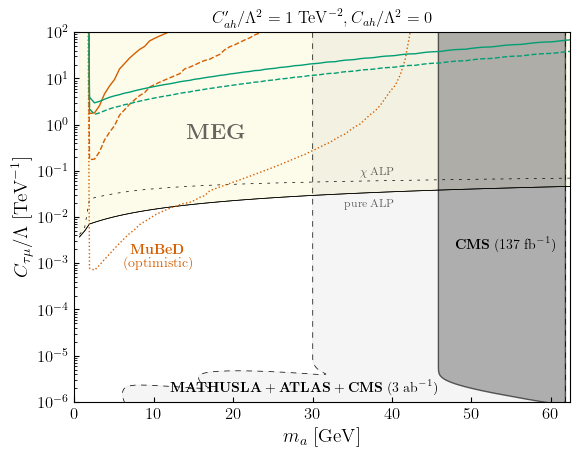

In [17]:
Cll = [[1, 1, 1], # Coupling hierarchy matrix
       [1, 1, 1], # (only C_{\tau \mu} non-zero)
       [1, 1, 1]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

Cah = 1e0
which = 'Cahp' #plotting limits with Cah' = 1.0/TeV^2

ma = np.linspace(0, 62.5, 100)

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}
MuSIC_optimistic = {'tau_efficiency': 0.1}
MuSIC_params = [MuSIC_conservative, MuSIC_optimistic]

# Different MuBeD scenarios
MuBeD_1e16 = {'N_MOT': 1e16}
MuBeD_1e18 = {'N_MOT': 1e18}
MuBeD_optimistic = {'target_length': 200, 'track_resolution': 0.2, 'N_MOT': 1e20}
MuBeD_params = [MuBeD_1e16, MuBeD_1e18, MuBeD_optimistic] 

# Compute and plot the limits
ax = plot_ALP_limits(ma, ij, Cah, which = which, Cll = Cll, MuSIC_params = MuSIC_params, MuBeD_params = MuBeD_params)

# Text for experiments
ax.text(14, 5e-1, '${\\bf MEG}$', fontsize = 16, alpha = 0.6)
ax.text(36, 8e-2, '$\\chi\ {\\rm ALP}$', fontsize = 8, alpha = 0.6)
ax.text(34, 1.6e-2, '${\\rm pure\ ALP}$', fontsize = 8, alpha = 0.6)
ax.text(48, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
ax.text(12, 1.6e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)
ax.text(7, 1.6e-3, '${\\bf MuBeD}$', color = colors[3], fontsize = 10)
ax.text(6.3, 8.0e-4, '${\\rm (optimistic)}$', color = colors[3], fontsize = 10)

# x-axis
ax.set_xlim(0, 62.5)

# y-axis
ax.set_ylim(1e-6, 1e2)
ax.set_yscale('log')
ax.set_ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

# Title
ax.set_title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

plt.savefig('figures/chapter5/MuBeD_optimistic.pdf', format = 'pdf', bbox_inches='tight')

## LFV Scalars

Here, we generate some plots for LFV scalars with $g_{\tau \ell}$ the only non-zero coupling. This is a natural extension to the above work, since one can essentially replace $g_{\tau \ell} \sim m_\tau C_{\tau \ell}/\Lambda$ (although there is a slightly more complicated dependence on the PV angle $\theta$ which we take into account in the code). We plot these alongside some explanations to the electron and muon $g-2$ anomalies.

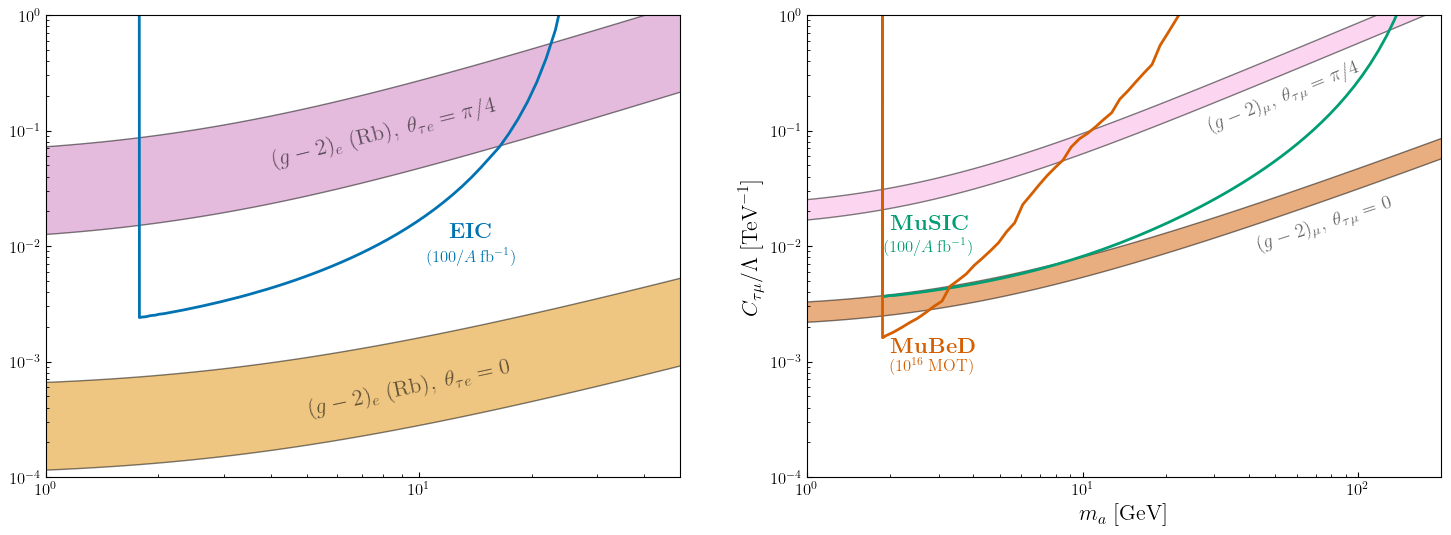

In [18]:
Cll = [[0, 0, 1], # Coupling hierarchy matrix 
       [0, 0, 0], # (only C_{\tau e} non-zero)
       [1, 0, 0]]
ij = (0, 2) # Plotting constraints on C_{\tau e}

fig = plt.figure(figsize = (18, 6))
gs = GridSpec(1, 2, wspace = 0.2)

# LEFT PLOT
ax1 = fig.add_subplot(gs[0])

ma = EIC.cached_masses('exact', 1.0, 'e', 'scalar')
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100))) # Finer precision near tau mass threshold


# Plot EIC limits
limit = EIC_limit(ma, g = Cll, idx = ij, ALP = False, **EIC_conservative)
ax1.plot(ma, limit, color = color_dict[EIC], linewidth = 2)

# Text for EIC
ax1.text(12, 1.2e-2, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax1.text(10.5, 7.4e-3, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

# Plot explanations to Rubidium anomaly for different angles
angles = np.array([0, 1]) * np.pi/4
angle_colors = [colors[1], colors[4]]
for angle, color in zip(angles, angle_colors):
    ax1.fill_between(ma, *g_2_explanation(ma, 'e Rb', ij, th = angle*np.ones((3, 3)), ALP = False),
                     alpha = 0.5, color = color, edgecolor = 'black')

# Text specifying PV angle
ax1.text(4, 5e-2, '${(g-2)_e~({\\rm Rb})},~\\theta_{\\tau e} = \\pi/4$',
         rotation = 14, fontsize = 16, alpha = 0.6)
ax1.text(5, 3.5e-4, '${(g-2)_e~({\\rm Rb})},~\\theta_{\\tau e} = 0$',
         rotation = 12, fontsize = 16, alpha = 0.6)

# Axis specifications
ax1.tick_params(which = 'both', direction = 'in', labelsize = 12)

# x-axis
ax1.set_xlim(1.0, 50)
ax1.set_xscale('log')

# y-axis
ax1.set_yscale('log')
ax1.set_ylim(1e-4, 1e0)

# RIGHT PLOT
ax2 = fig.add_subplot(gs[1])

ma = MuSIC.cached_masses('exact', 1.0, 'mu', 'scalar')
ma = np.sort(np.append(ma, np.linspace(1.0, 2.0, 100))) # Finer precision near tau mass threshold

#### MuSIC Limits ####

Cll = [[0, 0, 0], # Coupling hierarchy matrix 
       [0, 0, 1], # (only C_{\tau \mu} non-zero)
       [0, 1, 0]]
ij = (1, 2) # Plotting constraints on C_{\tau \mu}

# Conservative and optimistic MuSIC scenarios
MuSIC_conservative = {'tau_efficiency': 0.01}

# Compute and plot MuSIC limits

limit = MuSIC_limit(ma, g= Cll, idx = ij, ALP = False, **MuSIC_conservative)
ax2.plot(ma, limit, color = color_dict[MuSIC], linewidth = 2)

# Text for MuSIC
ax2.text(2.0, 1.4e-2, '${\\bf MuSIC}$', fontsize = 16, color = colors[2])
ax2.text(1.9, 9e-3, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[2])

### MuBeD Limits ####

# Different MuBeD scenarios
MuBeD_1e18 = {'N_MOT': 1e18}

# Compute and plot MuBeD limits

limit = MuBeD_limit(ma, g= Cll, idx = ij, ALP = False, **MuBeD_1e16)
ax2.plot(ma, limit, color = color_dict[MuBeD], linewidth = 2)

# Format tick parameters
ax2.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# Text for MuBeD
ax2.text(2.0, 1.2e-3, '${\\bf MuBeD}$', fontsize = 16, color = colors[3])
ax2.text(2.0, 0.85e-3, '$(10^{16}~{\\rm MOT})$', fontsize = 12, color = colors[3])

# Plot explanations to muon g-2 anomaly for different angles
angles = np.array([0, 1]) * np.pi/4
angle_colors = [colors[3], colors[6]]
for angle, color in zip(angles, angle_colors):
    plt.fill_between(ma, *g_2_explanation(ma, 'mu', ij, th = angle*np.ones((3, 3)), ALP = False),
                     alpha = 0.5, color = color, edgecolor = 'black')

# Text specifying PV angle
ax2.text(28, 1.0e-1, '$(g-2)_{\\mu},~\\theta_{\\tau \\mu} = \\pi/4$',
         rotation = 22, fontsize = 14, alpha = 0.6)
ax2.text(42, 9.3e-3, '$(g-2)_{\\mu},~\\theta_{\\tau \\mu} = 0$',
         rotation = 18, fontsize = 14, alpha = 0.6)
# x-axis
ax2.set_xlim(1.0, 200)
ax2.set_xscale('log')
ax2.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax2.set_ylim(1e-4, 1e0)
ax2.set_yscale('log')
ax2.set_ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)

plt.savefig('figures/chapter4/lfv_scalar_limits_and_g_2.pdf', format = 'pdf',bbox_inches='tight')

Similar to before, we can also plot the region for which the EIC, MuBeD, and MuSIC probe an explanation to the $g-2$ anomaly. 

In [19]:
gll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

masses = np.linspace(0, 25, 100)
masses = np.sort(np.append(masses, np.linspace(1, 2, 100)))

# List of angles to scan over
theta = np.linspace(0, 2, 10000)* np.pi/4

# Convert couplings and angles to a matrix that
# can be passed through the g_2_explanation function
gll_mat = np.array(gll).reshape(3, 3, 1, 1).repeat(10000, axis = 3)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

Cs_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Cs', (2, 0), g = gll_mat, th = theta_mat, ALP = False)
Cs_max = np.max(Cs_explanation, axis = 0)

Rb_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Rb', (2, 0), g = gll_mat, th = theta_mat, ALP = False)
Rb_max = np.max(Rb_explanation, axis = 0)

# Limits on Cet from the EIC
get_EIC = EIC_limit(masses, g = gll, tau_efficiency = 0.01, ALP = False).reshape(-1, 1)

#We want those values of m and theta for which C_explanation > C_EIC_lim
Cs_line = find_contours(masses, theta, (Cs_max - get_EIC), 0)[0]
Rb_line = find_contours(masses, theta, (Rb_max - get_EIC), 0)[0]


gll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]

# List of angles to scan over
theta = np.linspace(0, np.pi/4, 10000)

# Convert couplings and angles to a matrix that
# can be passed through the g_2_explanation function
gll_mat = np.array(gll).reshape(3, 3, 1, 1).repeat(10000, axis = 3)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

masses = np.geomspace(1, 200, 100)
masses = np.sort(np.append(masses, np.linspace(1, 2, 100)))

g_mu_explanation = g_2_explanation(masses.reshape(-1, 1), 'mu', (2, 1), g = gll_mat, th = theta_mat, ALP = False)
g_mu_max = np.max(g_mu_explanation, axis = 0)

# Limits on Cmt from MuSIC
gmt_MuSIC = MuSIC_limit(masses, g = gll, tau_efficiency = 0.01, ALP = False).reshape(-1, 1)

# Limits on Cmt from MuBeD
gmt_MuBeD = MuBeD_limit(masses, g = gll, N_MOT = 1e16, ALP = False).reshape(-1, 1)

#We want those values of m and theta for which C_explanation > C_MuSIC_lim, C_MuBeD_lim
MuSIC_line_cons = find_contours(masses, theta, (g_mu_max - gmt_MuSIC), 0)[1]
MuBeD_line_1e16 = find_contours(masses, theta, (g_mu_max - gmt_MuBeD), 0)[1]

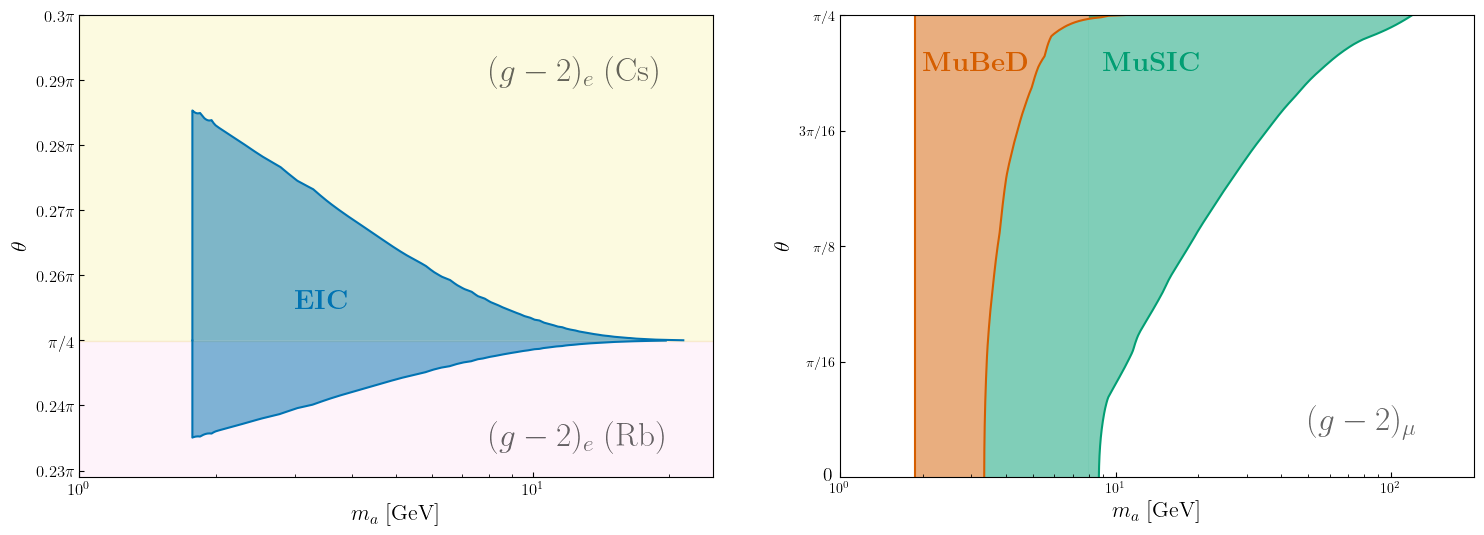

In [20]:
fig = plt.figure(figsize = (18, 6))
gs = GridSpec(1, 2, wspace = 0.2)

# LEFT PLOT
ax1 = fig.add_subplot(gs[0])

# Color plot
plt.fill_between(masses, 0.1*np.pi, np.pi/4-me/mt, color = colors[6], alpha = 0.15)
plt.fill_between(masses, np.pi/4-me/mt, 1.3*np.pi, color = colors[8], alpha = 0.15)

# Fill between EIC region
x, y = Cs_line
plt.fill_between(*Cs_line, np.pi/4, color = color_dict[EIC], alpha = 0.5, edgecolor = None)

x, y = Rb_line
plt.fill_between(*Rb_line, np.pi/4, color = color_dict[EIC], alpha = 0.5, edgecolor = None)

# Plot the outline of the region
plt.plot(*Cs_line, color = color_dict[EIC])
plt.plot(*Rb_line, color = color_dict[EIC])

# Text for EIC
plt.text(3, 0.255*np.pi, '${\\bf EIC}$', color = colors[0], fontsize = 20)


# Text identifying which anomaly is being probed
plt.text(8, 0.234*np.pi, '$(g-2)_{e}~({\\rm Rb})$', fontsize = 24, alpha = 0.6)
plt.text(8, 0.29*np.pi, '$(g-2)_{e}~({\\rm Cs})$', fontsize = 24, alpha = 0.6)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in', labelsize = 12) 

# x-axis
plt.xlim(1, 25)
plt.xscale('log')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(0.229*np.pi, 0.3*np.pi)
yticks = np.round(np.arange(0.23, 0.301, 0.01), 3)

plt.yticks(yticks*np.pi, [f'$\\pi/4$' if tick == 0.25 else f'${tick}\\pi$' for tick in yticks])
plt.ylabel('$\\theta$', fontsize = 16)

# RIGHT PLOT
ax2 = fig.add_subplot(gs[1])

# Fill between MuSIC region
y, x = MuSIC_line_cons[::-1]
x = smooth(x, window = 1000)
plt.fill_betweenx(y, x, 8, color = color_dict[MuSIC], alpha = 0.5, edgecolor = None)

# Plot MuSIC region
plt.plot(x, y, color = colors[2])

# Fill between MuBeD 1e16 region
y, x = MuBeD_line_1e16[::-1]
plt.fill_betweenx(y, x, mt+mm, color = color_dict[MuBeD], alpha = 0.5, edgecolor = None)

# Plot MuBeD 1e16 region
plt.plot(x, y, color = color_dict[MuBeD])

# Fill between MuBeD 1e16 and MuSIC scenario
plt.fill_betweenx(y, x, 8.01, color = color_dict[MuSIC], alpha = 0.5, edgecolor = None)

plt.axvline(mt+mm, 0, color = color_dict[MuBeD])
plt.axhline(np.pi/4+mm/mt-0.004, 0.12, 0.92, color = color_dict[MuSIC])
plt.axhline(np.pi/4+mm/mt-0.004, 0.12, 0.6, color = color_dict[MuBeD])
plt.axhline(np.pi/4 + mm/mt, linestyle = 'dashed', linewidth = 1, color = 'black')

# Muon (g-2)_mu text
plt.text(50, 0.08, '$(g-2)_{\\mu}$', fontsize = 24, alpha = 0.6)

# Text for MuSIC
plt.text(9, 0.22*np.pi, '${\\bf MuSIC}$', color = colors[2], fontsize = 20)

# Text for MuBeD
plt.text(2, 0.22*np.pi, '${\\bf MuBeD}$', color = colors[3], fontsize = 20)


# Format tick parameters
plt.tick_params(which = 'both', direction = 'in')

# x-axis
plt.xlim(1e0, 2e2)
plt.xscale('log')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.ylim(0, np.pi/4)
plt.ylabel('$\\theta$', fontsize = 16)
plt.yticks([np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4],
           ['$\\pi/16$', '$\\pi/8$', '$3\\pi/16$', '$\\pi/4$'])

plt.text(0.87, -0.005, '$0$', fontsize = 14) #input origin by hand to avoid collision with x-axis

# Save figure
plt.savefig('figures/chapter4/scalar_g_2_experiment_probes.pdf', format = 'pdf', bbox_inches='tight')